# Project 242

## Import

In [80]:
from backtester.backtesting import Strategy
from modules.data_preprocessing import *
from modules.add_features import *
from modules.metrics_prediction import *
from modules.metrics_performance import *
from modules.models import *
from modules.utils import *

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rd

## I. Data

### 1. Load data

In [82]:
data = pd.read_csv('data/Binance_BTCUSDT_1h.csv')

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
0,1.637280e+12,2021-11-19 00:00:00,BTC/USDT,56891.62,57247.58,56674.00,57144.98,719.65701,4.099574e+07,19977.0
1,1.637276e+12,2021-11-18 23:00:00,BTC/USDT,56613.30,56987.57,56474.26,56891.62,2553.36240,1.447890e+08,76763.0


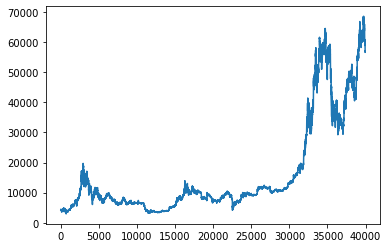

In [83]:
plt.plot(data[::-1].reset_index().close)
data.head(2)

### 2. Preprocess data

- clean data
- add features

In [84]:
# Clean data
data = clean_data(data)
data = data.rename(columns = {'Volume USDT': 'Volume'})

Here, we can decide to add features ...

In [85]:
# Add features
data = add_technical_indicators(data, lookback_period=30)[30:]

In [86]:
data.loc[data['VWAP'].isna(), 'VWAP'] = 0

In [87]:
# Split data
train_data, test_data = split_data(data, split=0.25)

train_data = array_to_df(train_data, data.columns)
test_data = array_to_df(test_data, data.columns)

print(f'Shape X_train: {train_data.shape} | X_test: {test_data.shape}')

Shape X_train: (29936, 13) | X_test: (9978, 13)


In [88]:
# Add Return
train_data = add_return(train_data)
test_data = add_return(test_data)

In [89]:
# Add Signal
train_data = add_signal(train_data, 0.001)
test_data = add_signal(test_data, 0.001)

## II. Model

### 1. Get data ready for models

In this section, the reformating of the data may depend on the model ...

In [102]:
train = prepare_data_2D_format(train_data, lookback_period = 5)
test = prepare_data_2D_format(test_data, lookback_period = 5, undersample = False)
test = test[:-5]

X_train = train
X_train = X_train.drop(['Signal'], axis = 1)
y_train = train['Signal']

X_test = test
X_test = X_test.drop(['Signal'], axis = 1)
y_test = test['Signal']

/Users/noemielevy/INDENG-242-project/modules/data_preprocessing.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(X), S, R


### 2. Build model

I am training a **random forest** model, using cross-validation to find the best max_features parameters.

In [91]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(min_samples_leaf=5, n_estimators = 500, random_state=88, verbose=0)
rf.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=5, n_estimators=500, random_state=88)

In [103]:
y_pred = rf.predict(X_test)

### 3. Test prediction model

In [105]:
TPR = get_TPR_FPR(y_test, y_pred)[0]
FPR = 0
F1 = get_F1(y_test, y_pred)
ACC = get_ACC(y_test, y_pred)
WACC = 0#get_WACC(y_test, y_pred, test_data.close)

In [106]:
models = ['Random Forest']
metrics = ['TPR', 'FPR', 'ACC', 'F1', 'WACC']
metric_data = [[TPR, FPR, ACC, F1, WACC]]

pd.DataFrame(metric_data, index=models, columns=metrics)

,TPR,FPR,ACC,F1,WACC
Random Forest,0.342414,0,0.401986,0.254763,0


### III. Strategy

### 1. Get data ready for backtesting

In [107]:
signal = pd.Series(y_pred)
close = test_data.close
signal.describe()

count    9968.000000
mean       -0.758628
std         0.647541
min        -1.000000
25%        -1.000000
50%        -1.000000
75%        -1.000000
max         1.000000
dtype: float64

In [108]:
# Crop for better visualization
nb_days = 1

signal_crop = crop_window(signal, nb_days)
close_crop = crop_window(close, nb_days)

### 2. Backtesting

In [109]:
strat = Strategy(cash=500, fees=0.001)

In [110]:
strat.run(signal_crop, close_crop, verbose=False)

In [111]:
wallet = np.array(strat.wallet)
profit_list = [0]
for i in range(1, len(wallet)):
    profit_list.append(wallet[i]-wallet[i-1])
    
profit = np.array(profit_list)

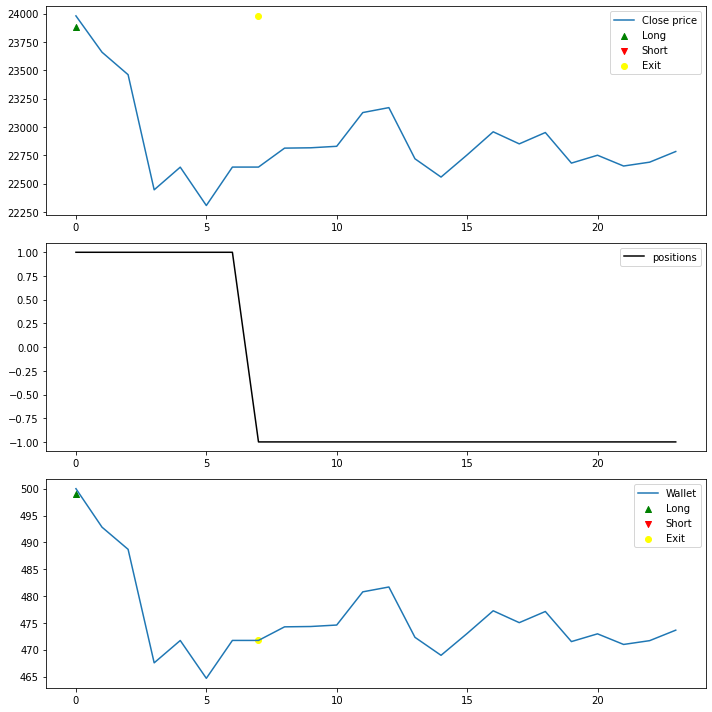

In [112]:
strat.visualize()

### 3. Test performance startegy

In [113]:
r_SharpeRatio = SharpeRatio(profit)
r_MaxDrawback = MaxDrawback(profit)
r_WinLossRatio = WinLossRatio(profit)
r_CumulativeProfit = CumulativeProfit(profit)
r_MeanProfit = MeanProfit(profit)

In [114]:
models = ['Random Forest']
metrics = ['SharpeRatio', 'MaxDrawback', 'WinLossRatio', 'CumulativeProfit', 'MeanProfit']
metric_data = [[r_SharpeRatio, r_MaxDrawback, r_WinLossRatio, r_CumulativeProfit, r_MeanProfit]]

pd.DataFrame(metric_data, index=models, columns=metrics)

,SharpeRatio,MaxDrawback,WinLossRatio,CumulativeProfit,MeanProfit
Random Forest,-0.182466,-21.149805,1.444444,-26.364804,-1.054592
